Distribution des données dans l'ensemble d'entraînement:
surprise: 3171 images
fear: 4097 images
angry: 3995 images
neutral: 4965 images
sad: 4830 images
disgust: 436 images
happy: 7215 images

Distribution des données dans l'ensemble de test:
surprise: 831 images
fear: 1024 images
angry: 958 images
neutral: 1233 images
sad: 1247 images
disgust: 111 images
happy: 1774 images


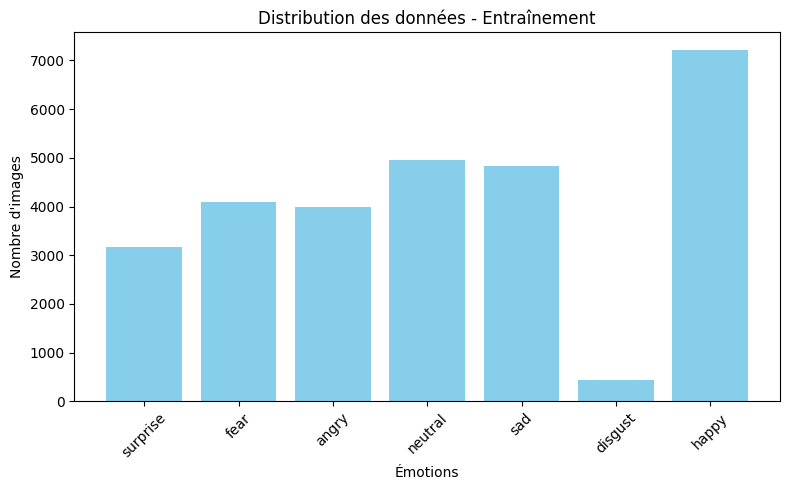

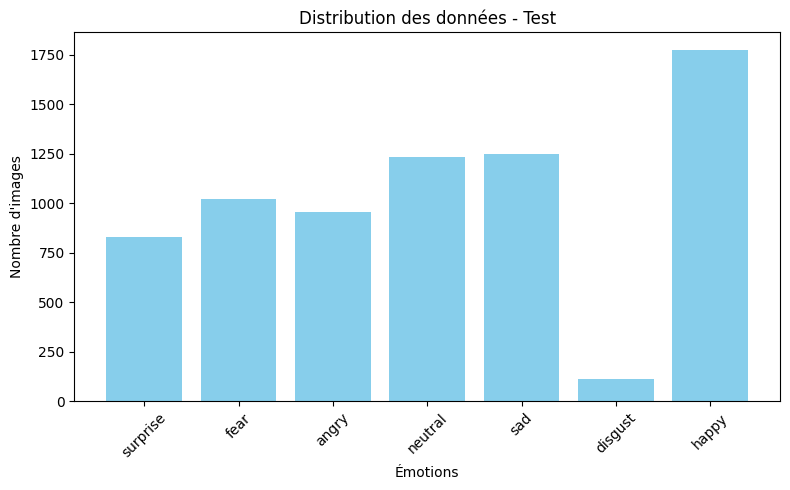

In [1]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt

# Chemins des répertoires
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

def explore_data(directory):
    """
    Fonction pour explorer la structure des données dans un répertoire donné.
    Retourne un dictionnaire contenant les classes et le nombre d'images par classe.
    """
    data_distribution = defaultdict(int)
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            data_distribution[class_name] = len(os.listdir(class_path))
    return data_distribution

# Explorer les ensembles d'entraînement et de test
train_distribution = explore_data(train_dir)
test_distribution = explore_data(test_dir)

# Afficher les résultats
print("Distribution des données dans l'ensemble d'entraînement:")
for emotion, count in train_distribution.items():
    print(f"{emotion}: {count} images")

print("\nDistribution des données dans l'ensemble de test:")
for emotion, count in test_distribution.items():
    print(f"{emotion}: {count} images")

# Visualisation des distributions
def plot_distribution(distribution, title):
    emotions = list(distribution.keys())
    counts = list(distribution.values())
    
    plt.figure(figsize=(8, 5))
    plt.bar(emotions, counts, color='skyblue')
    plt.title(title)
    plt.xlabel("Émotions")
    plt.ylabel("Nombre d'images")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_distribution(train_distribution, "Distribution des données - Entraînement")
plot_distribution(test_distribution, "Distribution des données - Test")


Étape 2 : Mise en œuvre de l'augmentation des données


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Générateur avec augmentation pour entraîner
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Générateur sans augmentation pour le test
test_datagen = ImageDataGenerator(rescale=1./255)

# Charger les données avec les chemins
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/fer2013/train',
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/fer2013/test',
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


> Étape 3 : Intégrer la pondération des classes dans la fonction de perte


In [3]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Classes dans l'ordre donné par le générateur
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

# Calculer les poids des classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))
print("Poids des classes :", class_weights)


Poids des classes : {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Définir le modèle CNN avec Input
model = Sequential([
    Input(shape=(48, 48, 3)),  # Utilisez Input pour spécifier la forme d'entrée
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
     Dense(7, activation='softmax')  # 7 classes pour les émotions
])

# Résumé du modèle
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,423 (1.36 MB)

 Trainable params: 356,423 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Compiler le modèle
model.compile(
    optimizer='adam',  # Ou un autre optimiseur comme SGD, RMSprop, etc.
    loss='categorical_crossentropy',  # Puisque nous avons plusieurs classes
    metrics=['accuracy']  # Pour suivre la précision pendant l'entraînement
)

# Ensuite, entraînez le modèle
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=2,  # Vous pouvez ajuster selon vos besoins
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)


Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


897/897 ━━━━━━━━━━━━━━━━━━━━ 195s 212ms/step - accuracy: 0.2486 - loss: 1.8168 - val_accuracy: 0.2669 - val_loss: 1.7641
Epoch 2/2
  1/897 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3438 - loss: 1.7931

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - accuracy: 0.3438 - loss: 1.7931 - val_accuracy: 0.1000 - val_loss: 2.0841


In [6]:
# Évaluer la performance sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Perte sur le test : {test_loss}")
print(f"Exactitude sur le test : {test_accuracy}")


225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.1960 - loss: 1.8459
Perte sur le test : 1.7628693580627441
Exactitude sur le test : 0.26706603169441223


In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Prédictions sur l'ensemble de test
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtenir les vraies étiquettes
y_true = test_generator.classes

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)
print("Matrice de confusion:\n", cm)

# Rapport de classification
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print("Rapport de classification:\n", report)


225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step
Matrice de confusion:
 [[  16    0   19  584    9  322    8]
 [   0    0    1   80    0   30    0]
 [   4    0   20  707   19  270    4]
 [   5    0   17 1344   20  386    2]
 [   1    0    6  836   27  362    1]
 [   5    0   14  726   22  477    3]
 [   3    0   42  623   16  114   33]]
Rapport de classification:
               precision    recall  f1-score   support

       angry       0.47      0.02      0.03       958
     disgust       0.00      0.00      0.00       111
        fear       0.17      0.02      0.03      1024
       happy       0.27      0.76      0.40      1774
     neutral       0.24      0.02      0.04      1233
         sad       0.24      0.38      0.30      1247
    surprise       0.65      0.04      0.07       831

    accuracy                           0.27      7178
   macro avg       0.29      0.18      0.13      7178
weighted avg       0.31      0.27      0.18      7178



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


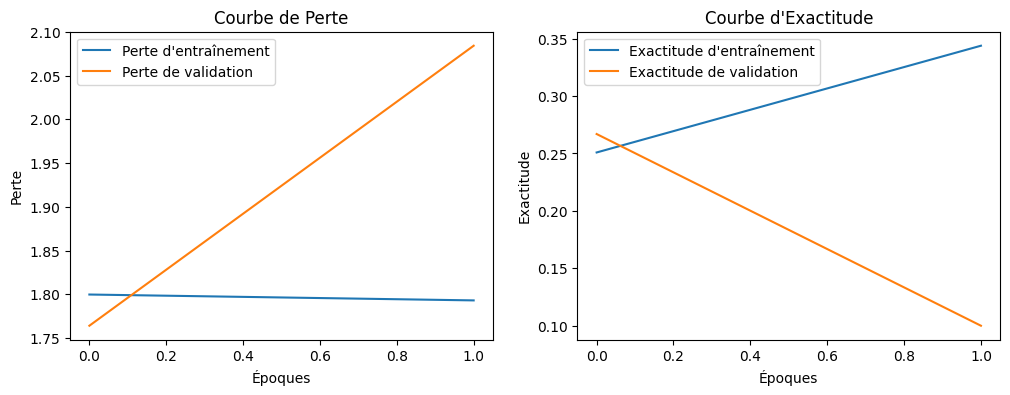

In [8]:
import matplotlib.pyplot as plt

# Visualisation des courbes d'entraînement
plt.figure(figsize=(12, 4))

# Perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.title('Courbe de Perte')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

# Exactitude
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Exactitude d\'entraînement')
plt.plot(history.history['val_accuracy'], label='Exactitude de validation')
plt.title('Courbe d\'Exactitude')
plt.xlabel('Époques')
plt.ylabel('Exactitude')
plt.legend()

plt.show()
